In [1]:
%%time
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd
import re
from bs4 import BeautifulSoup as bs
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize
import numpy as np
import string
from nltk.corpus import stopwords
import os
import email
from html.parser import HTMLParser
import matplotlib.pyplot as plt
import seaborn as sns

Wall time: 2.76 s


In [2]:
%%time
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

Wall time: 8.45 ms


In [3]:
df = pd.read_csv('C:/Users/bodie/Documents/Spreadsheets/emails_not_normalized.csv')

In [4]:

df['full_text'] = df['full_text'].apply(normalize_document)

In [80]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV


clf = LinearSVC(random_state=0, tol=1e-5)

calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=10,method='sigmoid')

text_clf = Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
('calibrated_clf',calibrated_clf)])

Wall time: 0 ns


In [28]:
print(text_clf)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('calibrated_clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0,
                                                                 tol=1e-05),
                                        cv=10))])


In [7]:
%%time

y = df['is_spam'].values
   
X = df['full_text'].tolist()


Wall time: 995 µs


In [8]:
X[0:5]

['amailbotwebde thu aug returnpath amailbotwebde deliveredto zzzzlocalhostspamassassintaintorg received localhost localhost phoboslabsspamassassintaintorg postfix esmtp id bc thu aug edt received mailwebnotenet localhost pop fetchmail zzzzlocalhost singledrop thu aug ist received ddit webnotenet esmtp id naa thu aug amailbotwebde received rsmtpkoreacom ddit microsoft smtpsvc sat aug 2 : 10 + 0900 : subject : life insurance - pay ? date : wed , 21 aug 2002 20 : 31 : 57 - 1600 mime - version : 1 . 0 message - id : < 0103c1042001882dd_it7 @ dd_it7 > content - type : text / html ; charset =" iso - 8859 - 1 " content - transfer - encoding : quoted - printable <= / tr > save 70 % life insurance . spend ? life quote savings ensurin = g family \' financial security important . life quote savings = kes buying life insurance simple affordable . provide free access = best companies lowest rates . life quote savings fast , eas = saves money ! let us help get started best val = ues country new cove

In [40]:
%%time
text_clf.fit(X,y)

Wall time: 2.96 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('calibrated_clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0,
                                                                 tol=1e-05),
                                        cv=5))])

In [41]:
%%time
text_clf.predict_proba(X)[:5, :]

Wall time: 2.28 s


array([[6.69868626e-04, 9.99330131e-01],
       [5.30192478e-02, 9.46980752e-01],
       [1.55632953e-03, 9.98443670e-01],
       [4.68789961e-03, 9.95312100e-01],
       [1.02974987e-01, 8.97025013e-01]])

In [12]:
df_idf = pd.DataFrame(text_clf['tfidf'].idf_, index=text_clf['vect'].get_feature_names(),columns=["idf_weights"]) 

df_idf.sort_values(by=['idf_weights'])

,idf_weights
date,1.000535
subject,1.001498
id,1.024019
received,1.025444
returnpath,1.026651
...,...
hovels,9.450412
57d10910d1f977334df9f1b25c6a2d08,9.450412
57c6,9.450412
howd,9.450412


In [13]:
%%time
probabilities = text_clf.predict_proba(X)

Wall time: 2.16 s


In [81]:
%%time
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

Wall time: 1.99 ms


In [82]:
%%time
text_clf.fit(X_train,y_train)

Wall time: 2.88 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('calibrated_clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0,
                                                                 tol=1e-05),
                                        cv=10))])

In [83]:
%%time
predictions = text_clf.predict(X_test)

Wall time: 606 ms


In [84]:
%%time
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1743
     class 1       0.99      0.99      0.99       596

    accuracy                           0.99      2339
   macro avg       0.99      0.99      0.99      2339
weighted avg       0.99      0.99      0.99      2339

Wall time: 6.03 ms


In [85]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [86]:
prob = text_clf.predict_proba(X_test)[:,1]

In [87]:
prob

array([2.30858326e-03, 3.13215611e-03, 7.24083182e-04, ...,
       1.31019360e-02, 9.98299982e-01, 2.07394108e-04])

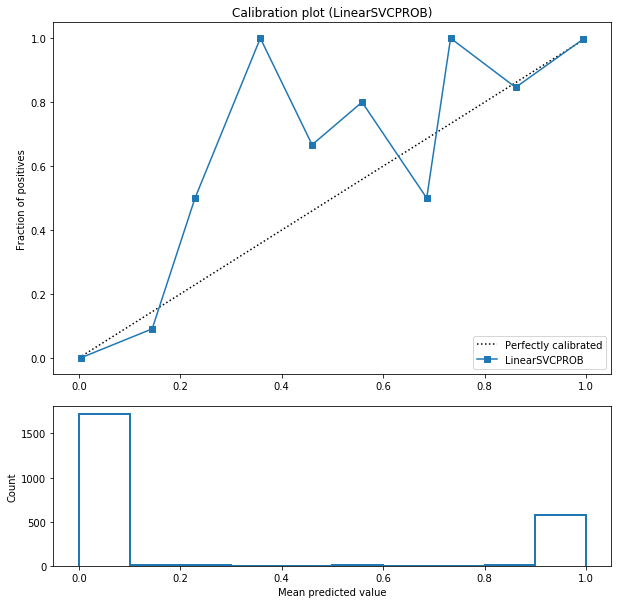

In [88]:
plot_calibration_curve('LinearSVCPROB',1, prob)

In [54]:
%%time
from sklearn.linear_model import LogisticRegression


lgr = LogisticRegression(C=1, solver='lbfgs')

calibrated_clf = CalibratedClassifierCV(base_estimator=lgr, cv=10,method='sigmoid')

lg_text_clf = Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
('calibrated_clf',calibrated_clf)])

lg_text_clf.fit(X_train,y_train)

lg_prob = lg_text_clf.predict_proba(X_test)[:,1]

Wall time: 9.64 s


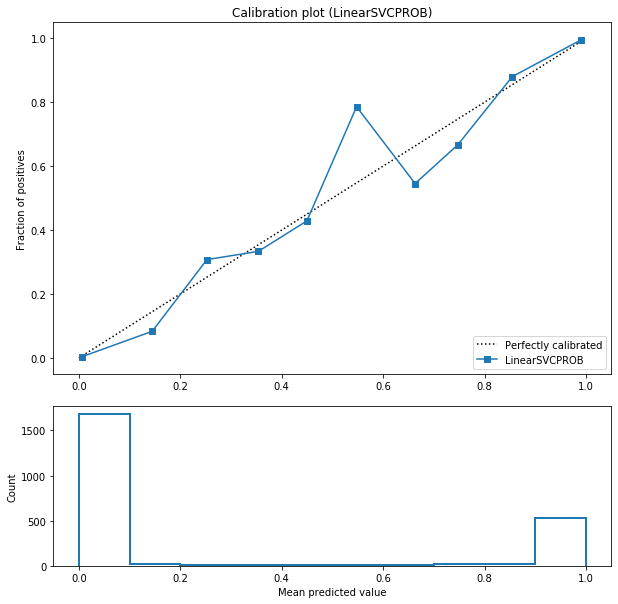

In [55]:
plot_calibration_curve('LinearSVCPROB',1, lg_prob)

In [17]:
df_idf.to_excel("weights.xlsx")

In [18]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(text_clf, open(filename, 'wb'))

In [19]:
test_prediction = X_test[0]

In [20]:
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [21]:

test_prediction = [test_prediction]

loaded_model.predict(test_prediction)

array([1], dtype=int64)